In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Attention
from keras import Input
from tensorflow.keras.models import Sequential, Model
import keras
from tqdm import tqdm
import matplotlib.pyplot as plt

print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/CPU:0")

Tensorflow version: 2.10.1
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
data = pd.read_parquet('datasets/cord-ner-full.parquet.gzip')
data

,word,entity,sentence
0,angiotensin-converting,B-GENE_OR_GENOME,0
1,enzyme,I-GENE_OR_GENOME,0
2,2,I-GENE_OR_GENOME,0
3,ace2,B-GENE_OR_GENOME,0
4,as,Other,0
...,...,...,...
63308695,advise,I-CHEMICAL,140498
63308696,caution,I-CHEMICAL,140498
63308697,in,I-CHEMICAL,140498
63308698,interpreting,I-CHEMICAL,140498


In [3]:
print(f"Number of unique entities: {len(data['entity'].unique())}")
data['entity'].unique()

Number of unique entities: 125


array(['B-GENE_OR_GENOME', 'I-GENE_OR_GENOME', 'Other', 'B-CORONAVIRUS',
       'B-CHEMICAL', 'B-EVOLUTION', 'B-WILDLIFE', 'B-NORP', 'I-NORP',
       'B-ORGANISM', 'B-EUKARYOTE', 'B-PERSON', 'I-PERSON',
       'B-PHYSICAL_SCIENCE', 'I-PHYSICAL_SCIENCE', 'I-CHEMICAL',
       'B-DISEASE_OR_SYNDROME', 'I-DISEASE_OR_SYNDROME', 'I-ORGANISM',
       'B-DATE', 'B-CARDINAL', 'B-MOLECULAR_FUNCTION',
       'B-EXPERIMENTAL_MODEL_OF_DISEASE',
       'I-EXPERIMENTAL_MODEL_OF_DISEASE', 'B-CELL',
       'B-BODY_PART_ORGAN_OR_ORGAN_COMPONENT', 'B-LIVESTOCK', 'B-ORG',
       'B-TISSUE', 'I-TISSUE', 'B-GROUP', 'I-CELL', 'B-CELL_COMPONENT',
       'I-CELL_COMPONENT', 'B-FOOD', 'B-CELL_FUNCTION', 'I-DATE', 'B-GPE',
       'B-DAILY_OR_RECREATIONAL_ACTIVITY', 'B-BODY_SUBSTANCE',
       'B-INDIVIDUAL_BEHAVIOR', 'B-GOVERNMENTAL_OR_REGULATORY_ACTIVITY',
       'B-ORDINAL', 'B-LABORATORY_PROCEDURE', 'I-LABORATORY_PROCEDURE',
       'B-VIRUS', 'B-PRODUCT', 'B-SIGN_OR_SYMPTOM',
       'B-LABORATORY_OR_TEST_RESUL

In [4]:
words = list(set(data['word'].values))
words.append("ENDPAD")
num_words = len(words)

tags = list(set(data['entity'].values))
num_tags = len(tags)

In [5]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s['word'].values.tolist(), s['entity'].values.tolist())]
        self.grouped = self.data.groupby('sentence').apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

# Init SentenceGetter object to preprocess and parse dataset into separate sentences
# 'sentences' object is an array of arrays, which contains tuples of word-entity pairs
getter = SentenceGetter(data)
sentences = getter.sentences
sentences[:1]

[[('angiotensin-converting', 'B-GENE_OR_GENOME'),
  ('enzyme', 'I-GENE_OR_GENOME'),
  ('2', 'I-GENE_OR_GENOME'),
  ('ace2', 'B-GENE_OR_GENOME'),
  ('as', 'Other'),
  ('a', 'Other'),
  ('sars-cov-2', 'B-CORONAVIRUS'),
  ('receptor', 'B-CHEMICAL'),
  ('molecular', 'Other'),
  ('mechanisms', 'Other'),
  ('and', 'Other'),
  ('potential', 'Other'),
  ('therapeutic', 'Other'),
  ('target', 'Other'),
  ('sars-cov-2', 'B-CORONAVIRUS'),
  ('has', 'Other'),
  ('been', 'Other'),
  ('sequenced', 'Other'),
  ('[3]', 'Other'),
  ('.', 'Other'),
  ('a', 'Other'),
  ('phylogenetic', 'B-EVOLUTION'),
  ('analysis', 'Other'),
  ('[3,', 'Other'),
  ('4]', 'Other'),
  ('found', 'Other'),
  ('a', 'Other'),
  ('bat', 'B-WILDLIFE'),
  ('origin', 'Other'),
  ('for', 'Other'),
  ('the', 'Other'),
  ('sars-cov-2', 'B-CORONAVIRUS'),
  ('there', 'Other'),
  ('is', 'Other'),
  ('a', 'Other'),
  ('diversity', 'Other'),
  ('of', 'Other'),
  ('possible', 'Other'),
  ('intermediate', 'B-NORP'),
  ('hosts', 'I-NORP'),
 

In [6]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

max_len = data.groupby(['sentence'], sort=False).size().max()

x = [[word2idx[w[0]] for w in s] for s in sentences]
x = pad_sequences(maxlen=max_len, sequences=x, padding="post", value=word2idx["ENDPAD"])

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx['Other'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [7]:
sentences[:2]

[[('angiotensin-converting', 'B-GENE_OR_GENOME'),
  ('enzyme', 'I-GENE_OR_GENOME'),
  ('2', 'I-GENE_OR_GENOME'),
  ('ace2', 'B-GENE_OR_GENOME'),
  ('as', 'Other'),
  ('a', 'Other'),
  ('sars-cov-2', 'B-CORONAVIRUS'),
  ('receptor', 'B-CHEMICAL'),
  ('molecular', 'Other'),
  ('mechanisms', 'Other'),
  ('and', 'Other'),
  ('potential', 'Other'),
  ('therapeutic', 'Other'),
  ('target', 'Other'),
  ('sars-cov-2', 'B-CORONAVIRUS'),
  ('has', 'Other'),
  ('been', 'Other'),
  ('sequenced', 'Other'),
  ('[3]', 'Other'),
  ('.', 'Other'),
  ('a', 'Other'),
  ('phylogenetic', 'B-EVOLUTION'),
  ('analysis', 'Other'),
  ('[3,', 'Other'),
  ('4]', 'Other'),
  ('found', 'Other'),
  ('a', 'Other'),
  ('bat', 'B-WILDLIFE'),
  ('origin', 'Other'),
  ('for', 'Other'),
  ('the', 'Other'),
  ('sars-cov-2', 'B-CORONAVIRUS'),
  ('there', 'Other'),
  ('is', 'Other'),
  ('a', 'Other'),
  ('diversity', 'Other'),
  ('of', 'Other'),
  ('possible', 'Other'),
  ('intermediate', 'B-NORP'),
  ('hosts', 'I-NORP'),
 

## Model definition

In [8]:
def build_model(dropout, optimizer_name, learning_rate):
    input_layer = Input(shape=(max_len,))
    embed = Embedding(input_dim=len(words), output_dim=100, input_length=max_len)(input_layer)
    rnn_1 = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0))(embed)
    rnn_drop = Dropout(dropout)(rnn_1)
    rnn_2 = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0))(rnn_drop)
    attention = Attention()([rnn_2, rnn_2])
    dense_1 = TimeDistributed(Dense(len(tags) * 4, activation="relu"))(rnn_2)
    dense_2 = TimeDistributed(Dense(len(tags) * 2, activation="relu"))(dense_1)
    out = keras.layers.Dense(units=len(tags), activation='softmax')(dense_2)
    
    
    model = Model(input_layer, out)
    
    model.summary()

    if optimizer_name == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate)
    elif optimizer_name == "Nadam":
        optimizer = tf.keras.optimizers.Nadam(learning_rate)
    elif optimizer_name == "RMSprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate)

    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

In [9]:
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import EarlyStopping

# early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=1)

def train():    
    config_defaults = {
        'dropout': 0,
        'batch_size_divisor': 4,
        'optimizer': 'Adam',
        'learning_rate': 0.01,
        'epochs': 1
    }

    wandb.init(config=config_defaults)

    config = wandb.config
    
    with strategy.scope():
        model = build_model(config.dropout, config.optimizer, config.learning_rate)

        history = model.fit(
            x=x_train,
            y=y_train,
            validation_split=0.1,
            batch_size=int(max_len/config.batch_size_divisor),
            epochs=config.epochs,
            verbose=1,
            callbacks=[
#                 early_stop,
#                 WandbCallback()
            ]
        )

    metrics = {
        'val_loss': history.history['val_loss'][-1],
        'val_accuracy': history.history['val_accuracy'][-1],
    }

    wandb.log(metrics)

#     print(config)

In [10]:
sweep_config = {
    'method': 'random',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'dropout': {
            'values': [0.2, 0.3, 0.4, 0.5, 0.6]
        },
        'batch_size_divisor': {
            'values': [2]
        },
        'optimizer': {
            'values': ['Nadam', 'Adam', 'RMSprop']
        },
        'learning_rate': {
            'min': 0.0001,
            'max': 0.001
        },
        'epochs': {
            'values': [6]
        }
    }
}

sweep_id = wandb.sweep(sweep_config)

wandb.agent(sweep_id, function=train, count=8)

Create sweep with ID: fla4xvjo
Sweep URL: https://wandb.ai/xkretinin/uncategorized/sweeps/fla4xvjo


wandb: Agent Starting Run: dfdzhm0f with config:
wandb: 	batch_size_divisor: 2
wandb: 	dropout: 0.2
wandb: 	epochs: 6
wandb: 	learning_rate: 0.0006247608963216003
wandb: 	optimizer: RMSprop
wandb: Currently logged in as: xkretinin. Use `wandb login --relogin` to force relogin


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding (Embedding)       (None, 512, 100)          95134600  
                                                                 
 bidirectional (Bidirectiona  (None, 512, 200)         160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 512, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 512, 500)         100500

val_accuracy,▁
val_loss,▁
val_accuracy,0.90955
val_loss,0.31934


wandb: Agent Starting Run: 5v2vbj35 with config:
wandb: 	batch_size_divisor: 2
wandb: 	dropout: 0.6
wandb: 	epochs: 6
wandb: 	learning_rate: 0.00026825871872622063
wandb: 	optimizer: Nadam


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding (Embedding)       (None, 512, 100)          95134600  
                                                                 
 bidirectional (Bidirectiona  (None, 512, 200)         160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 512, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 512, 500)         100500

val_accuracy,▁
val_loss,▁
val_accuracy,0.88912
val_loss,0.42395


wandb: Agent Starting Run: v2ki5iw8 with config:
wandb: 	batch_size_divisor: 2
wandb: 	dropout: 0.6
wandb: 	epochs: 6
wandb: 	learning_rate: 0.0008733551737148384
wandb: 	optimizer: Nadam


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding (Embedding)       (None, 512, 100)          95134600  
                                                                 
 bidirectional (Bidirectiona  (None, 512, 200)         160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 512, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 512, 500)         100500

val_accuracy,▁
val_loss,▁
val_accuracy,0.91446
val_loss,0.30374


wandb: Agent Starting Run: o3fu9jgo with config:
wandb: 	batch_size_divisor: 2
wandb: 	dropout: 0.3
wandb: 	epochs: 6
wandb: 	learning_rate: 0.0001223515052788552
wandb: 	optimizer: Adam


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding (Embedding)       (None, 512, 100)          95134600  
                                                                 
 bidirectional (Bidirectiona  (None, 512, 200)         160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 512, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 512, 500)         100500

val_accuracy,▁
val_loss,▁
val_accuracy,0.87501
val_loss,0.49599


wandb: Agent Starting Run: 8cv7e0bd with config:
wandb: 	batch_size_divisor: 2
wandb: 	dropout: 0.2
wandb: 	epochs: 6
wandb: 	learning_rate: 0.0007422336101051181
wandb: 	optimizer: RMSprop


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding (Embedding)       (None, 512, 100)          95134600  
                                                                 
 bidirectional (Bidirectiona  (None, 512, 200)         160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 512, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 512, 500)         100500

val_accuracy,▁
val_loss,▁
val_accuracy,0.91336
val_loss,0.30488


wandb: Agent Starting Run: b6cpzcjv with config:
wandb: 	batch_size_divisor: 2
wandb: 	dropout: 0.4
wandb: 	epochs: 6
wandb: 	learning_rate: 0.0006131957130971668
wandb: 	optimizer: Adam


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding (Embedding)       (None, 512, 100)          95134600  
                                                                 
 bidirectional (Bidirectiona  (None, 512, 200)         160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 512, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 512, 500)         100500

val_accuracy,▁
val_loss,▁
val_accuracy,0.91122
val_loss,0.31941


wandb: Agent Starting Run: 3kxhrds1 with config:
wandb: 	batch_size_divisor: 2
wandb: 	dropout: 0.3
wandb: 	epochs: 6
wandb: 	learning_rate: 0.0009508729384534216
wandb: 	optimizer: RMSprop


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding (Embedding)       (None, 512, 100)          95134600  
                                                                 
 bidirectional (Bidirectiona  (None, 512, 200)         160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 512, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 512, 500)         100500

val_accuracy,▁
val_loss,▁
val_accuracy,0.91766
val_loss,0.28723


wandb: Agent Starting Run: 2ogrhb2u with config:
wandb: 	batch_size_divisor: 2
wandb: 	dropout: 0.2
wandb: 	epochs: 6
wandb: 	learning_rate: 0.0008788700890802599
wandb: 	optimizer: RMSprop


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding (Embedding)       (None, 512, 100)          95134600  
                                                                 
 bidirectional (Bidirectiona  (None, 512, 200)         160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 512, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 512, 500)         100500

val_accuracy,▁
val_loss,▁
val_accuracy,0.91637
val_loss,0.29266


In [11]:
# sweep_obj = wandb.Api().sweep('peter-kudela/uncategorized/sweeps/' + sweep_id)
sweep_obj = wandb.Api().sweep('xkretinin/uncategorized/sweeps/' + sweep_id)
best_config = sweep_obj.best_run().config

print("Best run config:")
print(best_config)
print(f"Validation accuracy: {sweep_obj.best_run().summary['val_accuracy']}")

wandb: Sorting runs by -summary_metrics.val_accuracy
wandb: Sorting runs by -summary_metrics.val_accuracy


Best run config:
{'epochs': 6, 'dropout': 0.3, 'optimizer': 'RMSprop', 'learning_rate': 0.0009508729384534216, 'batch_size_divisor': 2}
Validation accuracy: 0.9176594018936156


In [12]:
model = build_model(best_config['dropout'], best_config['optimizer'], best_config['learning_rate'])
history = model.fit(
            x=x_train,
            y=y_train,
            validation_split=0.1,
            batch_size=int(max_len/best_config['batch_size_divisor']),
            epochs=best_config['epochs'],
            verbose=1
        )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 embedding (Embedding)       (None, 512, 100)          95134600  
                                                                 
 bidirectional (Bidirectiona  (None, 512, 200)         160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 512, 200)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512, 200)         240800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 512, 500)         100500

In [13]:
idx2tag = {v: k for k, v in tag2idx.items()}
idx2word = {i: w for w, i in word2idx.items()}

In [14]:
def visualize_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.show()

In [15]:
def plot_history(history):
    plt.style.use('ggplot')
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

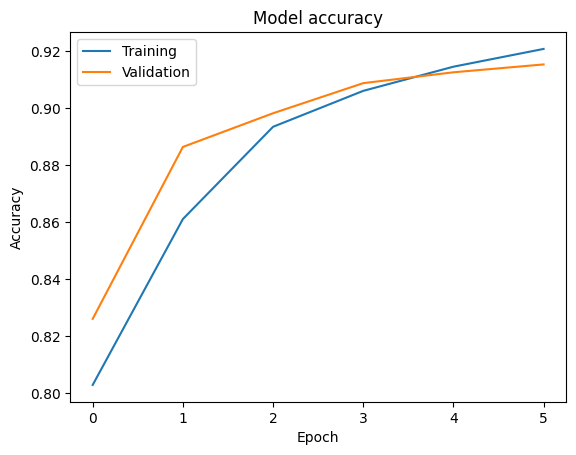

In [16]:
visualize_history(history)

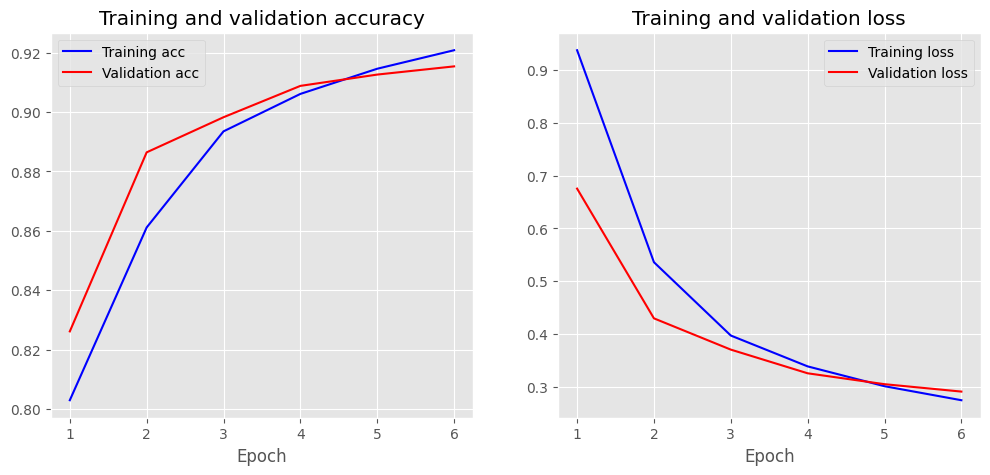

In [17]:
plot_history(history)

In [18]:
for i in range(3):
    p = model.predict(np.array([x_test[i]]))
    p = np.argmax(p, axis=-1)
    y_true = y_test[i]
    print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
    print("-" * 30)
    for w, true, pred in zip(x_test[i], y_true, p[0]):
        if words[w] == "ENDPAD":
            break
        print("{:15}{}\t{}".format(words[w], tags[true], tags[pred]))
    print("----------------------------")

1/1 [==============================] - 1s 705ms/step
Word           True 	 Pred

------------------------------
ranked         Other	Other
either         Other	Other
by             Other	Other
p              B-GENE_OR_GENOME	B-GENE_OR_GENOME
value          I-GENE_OR_GENOME	I-GENE_OR_GENOME
(eigenstrat,   Other	Other
emmax-grm      B-CHEMICAL	B-CHEMICAL
and            Other	Other
fvr            B-GENE_OR_GENOME	B-GENE_OR_GENOME
or             Other	Other
by             Other	Other
pve            B-GENE_OR_GENOME	B-GENE_OR_GENOME
gblup          B-CHEMICAL	B-CHEMICAL
from           Other	Other
1              Other	Other
(most          Other	Other
significant    Other	Other
snp)           Other	Other
to             Other	Other
2,000.         Other	Other
for            Other	Other
comparisons    Other	Other
of             Other	Other
snps           Other	Other
that           Other	Other
were           Other	Other
associated     Other	Other
with           Other	Other
brdc           Other	Oth

1/1 [==============================] - 0s 46ms/step
Word           True 	 Pred

------------------------------
cytrx          I-ORG	B-ORG
corporation    I-ORG	I-ORG
are            Other	Other
concentrated   Other	Other
in             Other	Other
the            Other	Other
development    Other	Other
of             Other	Other
small          B-PERSON	B-GENE_OR_GENOME
molecule       I-PERSON	I-GENE_OR_GENOME
drugs          B-THERAPEUTIC_OR_PREVENTIVE_PROCEDURE	B-THERAPEUTIC_OR_PREVENTIVE_PROCEDURE
rnai           B-MOLECULAR_FUNCTION	B-MOLECULAR_FUNCTION
drug           Other	Other
discovery      Other	Other
and            Other	Other
dna            B-CELL_COMPONENT	B-CELL_COMPONENT
vaccines       B-CHEMICAL	B-CHEMICAL
and            Other	Other
a              Other	Other
delivery       Other	Other
technology     Other	Other
with           Other	Other
multiple       Other	Other
applications   B-THERAPEUTIC_OR_PREVENTIVE_PROCEDURE	B-THERAPEUTIC_OR_PREVENTIVE_PROCEDURE
in             Other	Ot